## NN Adv Assignment

In [197]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [198]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [199]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [200]:
train['label'].nunique()

10

In [201]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [202]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

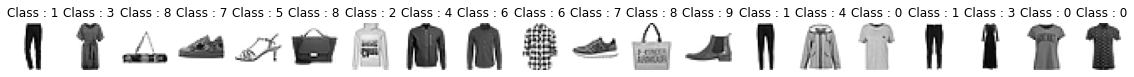

In [203]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [204]:
X_test = test.values

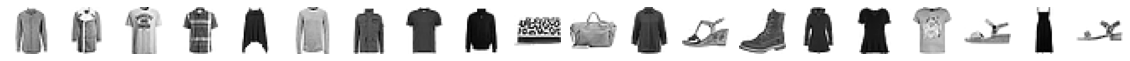

In [205]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

## 환경설정

In [206]:
# 하이퍼 파라미터
CFG = {
    'EPOCHS':15, #에포크
    'LEARNING_RATE':1e-3, #학습률
    'BATCH_SIZE':16, #배치사이즈
    'SEED':41, #시드
    'MOMENTUM': 0.9 # 관성
}

In [207]:
# Seed 고정
import random, os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [208]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [209]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    print('Device:', device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

No GPU available, using the CPU instead.


### Train-Valid Split

In [210]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=CFG['SEED'])


In [211]:
# Train, Valid, Test 길이

print(f"Train 길이: {len(X_train)}")
print(f"Valid 길이: {len(X_valid)}")
print(f"Test 길이: {len(X_test)}")

Train 길이: 47600
Valid 길이: 11900
Test 길이: 10500


## Dataset

In [212]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y, train_mode=True, transform=None):
        self.X = X/255.0
        self.y = y
        self.train_mode = train_mode
        self.transform = transform
        
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        
        if self.transform is not None:
            data = data.reshape(28,28)
            data = self.transform(data).reshape(28*28)
    
        if self.train_mode:
            return data, label
        
        else:
            return data
    
    def __len__(self):
        return len(self.X)
        

### BGD vs SGD vs MSGD(Pytorch Dataloader를 사용하는 이유)
<br>
<strong>BGD</strong>: 전체 데이터셋에 대해서 Gradient계산 후 Parameter를 업데이트 하는 알고리즘
<br><br>
<strong>SGD</strong>: 랜덤으로 추출된 데이터 한 개에 대해서 Gradient계산 후 Parameter를 업데이트 하는 알고리즘
<br><br>
<strong>MSGD</strong>: 전체 데이테섯을 N개의 미니 배치로 나누어서 N개의 배치 단위마다 기울기 N개 귀한 뒤, 그것의 평균 기울기를 통해 모델을 업데이트 하는 방법

In [213]:
transform = transforms.ToTensor()

# MGSD 방식을 사용하기 위해 DataLoader를 사용
train_dataset = CustomDataset(X_train, y_train, True, transform)
# DataLoader: dataset을 batch단위로 끊기 위해서 사용
train_loader = DataLoader(train_dataset, batch_size= CFG['BATCH_SIZE'], shuffle=True)

valid_dataset = CustomDataset(X_valid, y_valid, True, transform)
valid_loader = DataLoader(valid_dataset, batch_size= CFG['BATCH_SIZE'], shuffle=True)


## Model

### Baseline_Model
두 개의 fc layer로 구성되어 있습니다. 
#### 1. layer1 : 784->128, ReLU
#### 2. layer2 : 128->10, ReLU

In [214]:
class Baesline_Model(torch.nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        self.fc0 = nn.Linear(in_feature, 128)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128,128)
        self.fc2 = nn.Linear(128,out_feature)

    def forward(self, x):
        x = self.relu(self.fc0(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## Train

In [245]:
from tqdm.auto import tqdm

def train(optimizer_dict, train_loader, valid_loader, device): 
    for optimizer_name, optimizer in optimizer_dict.items():
        print(optimizer_name)
        model = model_dict[optimizer_name].to(device)
        criterion = torch.nn.CrossEntropyLoss().to(device)
        n = len(train_loader)
        best_acc = 0

        for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
            model.train() #모델 학습
            running_loss = 0.0
            
            for data, label in tqdm(iter(train_loader)):
                data, label = data.to(device).float(), label.to(device) #배치 데이터
                optimizer.zero_grad() #배치마다 optimizer 초기화

                # Data -> Model -> Output
                logit = model(data) #예측값 산출
                loss = criterion(logit, label) #손실함수 계산
                # 역전파
                loss.backward() #손실함수 기준 역전파 
                optimizer.step() #가중치 최적화
                running_loss += loss.item()

            print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))

            #Validation set 평가
            model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
            valid_loss = 0.0
            correct = 0
            with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
                for data, label in tqdm(iter(valid_loader)):
                    data, label = data.to(device).float(), label.to(device)

                    logit = model(data)
                    valid_loss += criterion(logit, label)
                    pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                    correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
            valid_acc = 100 * correct / len(valid_loader.dataset)
            valid_loss = valid_loss/ len(valid_loader.dataset)
            loss_dict[optimizer_name].append(valid_loss)
            accuracy_dict[optimizer_name].append(valid_acc)
            print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(valid_loss, correct, len(valid_loader.dataset), valid_acc))



### Optimizer(SGD, AdaGrad, Momentum, Adam)
<strong>SGD</strong>: 랜덤으로 추출된 데이터 한 개에 대해서 Gradient계산 후 Parameter를 업데이트 하는 알고리즘
<br><br>
$W=W-\eta\frac{\sigma L}{\sigma W}$
<br><br>
<strong>AdaGrad</strong>: 많이 변화하지 않은 변수들의 학습률을 크게하고, 반대로 많이 변화한 변수들에 대해서는 학습률을 적게하는 알고리즘
<br><br>
$h=h + (\frac{\sigma L}{\sigma W})^2$
<br>
$W=W-\eta\frac{1}{\sqrt{h}}\frac{\sigma L}{\sigma W}$
<br><br>
<strong>Momentum</strong>: 경사 하강법과 마찬가지로 매번 기울기를 구하지만, 가중치를 수정하기전 이전 수정 방향을 참고하여 같은 방향으로 더해주는 알고리즘
<br><br>
$v=\alpha v-\eta\frac{\sigma L}{\sigma W}$
<br>
$W=W+v$
<br><br>
<strong>Adam</strong>: AdaGrad 방식과 Momentum방식을 합친 알고리즘
<br><br>
$W=W-\eta\frac{1}{\sqrt{h}}\frac{\sigma L}{\sigma W} + v$
<br><br>

### Loss Function
손실함수로는 분류 문제이기 때문에 'CrossEntropyLoss'를 사용했습니다.
<br><br>
손실함수는 실제 값과 모델이 예측한 값의 거리를 출력하는 함수입니다.

In [216]:
model_dict = {}
loss_dict = {}
accuracy_dict = {}
# optimizer에 따른 학습 정도를 살펴볼 4가지 테스트 케이스
optimizer_case = ['SGD','AdaGrad','Momentum','Adam']
for key in optimizer_case:
    model_dict[key] = Baesline_Model(784,10)
    loss_dict[key] = []
    accuracy_dict[key] = []


In [217]:
optimizer_dict = {}
optimizer_dict['SGD'] = optim.SGD(model_dict['SGD'].parameters(),lr = CFG['LEARNING_RATE'] )
optimizer_dict['AdaGrad'] = optim.Adagrad(model_dict['AdaGrad'].parameters(), lr=CFG['LEARNING_RATE'])
optimizer_dict['Momentum'] = optim.SGD(model_dict['Momentum'].parameters(), lr=CFG['LEARNING_RATE'], momentum = CFG["MOMENTUM"])
optimizer_dict['Adam'] = optim.Adam(model_dict['Adam'].parameters(),lr= CFG['LEARNING_RATE'])
loss_function = nn.CrossEntropyLoss()

In [218]:
train(optimizer_dict, train_loader, valid_loader, device)

SGD


  0%|          | 0/2975 [00:00<?, ?it/s]

[1] Train loss: 1.9044537189


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0844, Accuracy: 7320/11900 ( 62%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[2] Train loss: 1.0781176606


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0572, Accuracy: 8051/11900 ( 68%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[3] Train loss: 0.8384322197


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0488, Accuracy: 8588/11900 ( 72%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[4] Train loss: 0.7402914869


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0443, Accuracy: 8941/11900 ( 75%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[5] Train loss: 0.6789348940


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0412, Accuracy: 9140/11900 ( 77%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[6] Train loss: 0.6338605096


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0387, Accuracy: 9360/11900 ( 79%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[7] Train loss: 0.5987802168


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0368, Accuracy: 9504/11900 ( 80%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[8] Train loss: 0.5712624492


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0355, Accuracy: 9600/11900 ( 81%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[9] Train loss: 0.5500908392


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0340, Accuracy: 9692/11900 ( 81%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[10] Train loss: 0.5324942955


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0333, Accuracy: 9711/11900 ( 82%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[11] Train loss: 0.5184373773


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0324, Accuracy: 9778/11900 ( 82%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[12] Train loss: 0.5067484626


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0319, Accuracy: 9806/11900 ( 82%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[13] Train loss: 0.4973840352


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0312, Accuracy: 9845/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[14] Train loss: 0.4887067373


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0307, Accuracy: 9855/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[15] Train loss: 0.4810269936


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0304, Accuracy: 9881/11900 ( 83%)

AdaGrad


  0%|          | 0/2975 [00:00<?, ?it/s]

[1] Train loss: 0.7663798663


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0394, Accuracy: 9358/11900 ( 79%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[2] Train loss: 0.5923727336


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0358, Accuracy: 9570/11900 ( 80%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[3] Train loss: 0.5518048101


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0340, Accuracy: 9667/11900 ( 81%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[4] Train loss: 0.5282481103


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0329, Accuracy: 9746/11900 ( 82%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[5] Train loss: 0.5120773630


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0321, Accuracy: 9781/11900 ( 82%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[6] Train loss: 0.4999792814


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0314, Accuracy: 9834/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[7] Train loss: 0.4902817455


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0309, Accuracy: 9855/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[8] Train loss: 0.4820178849


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0304, Accuracy: 9894/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[9] Train loss: 0.4750451233


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0301, Accuracy: 9924/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[10] Train loss: 0.4690436245


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0298, Accuracy: 9940/11900 ( 84%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[11] Train loss: 0.4637163492


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0295, Accuracy: 9957/11900 ( 84%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[12] Train loss: 0.4592511596


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0292, Accuracy: 9958/11900 ( 84%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[13] Train loss: 0.4548913520


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0290, Accuracy: 9969/11900 ( 84%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[14] Train loss: 0.4510320901


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0288, Accuracy: 9985/11900 ( 84%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[15] Train loss: 0.4475152853


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0287, Accuracy: 9999/11900 ( 84%)

Momentum


  0%|          | 0/2975 [00:00<?, ?it/s]

[1] Train loss: 0.8436779155


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0375, Accuracy: 9297/11900 ( 78%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[2] Train loss: 0.5136806575


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0298, Accuracy: 9878/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[3] Train loss: 0.4638934642


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0296, Accuracy: 9833/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[4] Train loss: 0.4334735511


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0273, Accuracy: 10010/11900 ( 84%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[5] Train loss: 0.4073270441


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0271, Accuracy: 10063/11900 ( 85%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[6] Train loss: 0.3883914792


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0243, Accuracy: 10257/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[7] Train loss: 0.3719830573


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0235, Accuracy: 10293/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[8] Train loss: 0.3565496627


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0240, Accuracy: 10249/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[9] Train loss: 0.3465679366


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0231, Accuracy: 10316/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[10] Train loss: 0.3375158421


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0229, Accuracy: 10330/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[11] Train loss: 0.3259160950


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0226, Accuracy: 10348/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[12] Train loss: 0.3162017634


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0220, Accuracy: 10383/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[13] Train loss: 0.3087884185


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0214, Accuracy: 10453/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[14] Train loss: 0.3019764475


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0221, Accuracy: 10369/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[15] Train loss: 0.2941440309


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0211, Accuracy: 10454/11900 ( 88%)

Adam


  0%|          | 0/2975 [00:00<?, ?it/s]

[1] Train loss: 0.5176509215


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0258, Accuracy: 10110/11900 ( 85%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[2] Train loss: 0.3903625446


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0236, Accuracy: 10285/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[3] Train loss: 0.3555991029


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0240, Accuracy: 10255/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[4] Train loss: 0.3314563678


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0221, Accuracy: 10391/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[5] Train loss: 0.3182344010


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0220, Accuracy: 10404/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[6] Train loss: 0.3027421920


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0233, Accuracy: 10300/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[7] Train loss: 0.2906683811


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0211, Accuracy: 10467/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[8] Train loss: 0.2794576186


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0220, Accuracy: 10430/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[9] Train loss: 0.2709542193


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0223, Accuracy: 10402/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[10] Train loss: 0.2640842236


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0212, Accuracy: 10480/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[11] Train loss: 0.2565763707


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0210, Accuracy: 10505/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[12] Train loss: 0.2491717805


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0210, Accuracy: 10514/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[13] Train loss: 0.2420620578


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0204, Accuracy: 10558/11900 ( 89%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[14] Train loss: 0.2349132058


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0223, Accuracy: 10392/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[15] Train loss: 0.2286954068


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0210, Accuracy: 10584/11900 ( 89%)



### Visualize

15
15
15
15


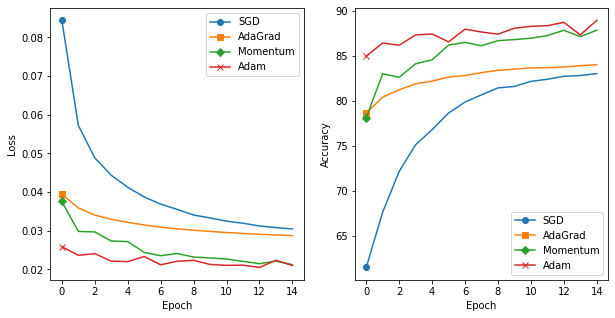

In [220]:
markers = {'SGD' : 'o', 'Adam' : 'x','AdaGrad' : 's', 'Momentum' : 'D' }
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
epochs = [i for i in range(CFG['EPOCHS'])]
for key in optimizer_case:
    print(len(loss_dict[key]))
    plt.plot(epochs,loss_dict[key], marker = markers[key], markevery=100, label = key)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.subplot(1,2,2)
for key in optimizer_case:
    plt.plot(epochs, accuracy_dict[key],marker = markers[key], markevery=100, label=key)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

가장 성능이 좋은 Optimizer는 Adam이였습니다. 

### Result(SGD vs AdaGrad vs Momentum vs Adam)

| Optimizer | Best Accuracy |
| -: | :-: |
| SGD | 84%
| AdaGrad | 85%
| Momentum | 87%
| Adam | 89%

## Batch Nomalization

In [241]:
class BatchNorm_Model(torch.nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        self.fc0 = nn.Sequential(
            nn.Linear(in_feature, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(128,128)
        self.fc2 = nn.Linear(128,out_feature)

    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [242]:
model_dict = {}
loss_dict = {}
accuracy_dict = {}
optimizer_case = ['Adam']
for key in optimizer_case:
    model_dict[key] = BatchNorm_Model(784,10)
    loss_dict[key] = []
    accuracy_dict[key] = []

In [243]:
optimizer_dict = {}
optimizer_dict['Adam'] = optim.Adam(model_dict['Adam'].parameters(),lr= CFG['LEARNING_RATE'])
loss_function = nn.CrossEntropyLoss()

In [246]:
train(optimizer_dict, train_loader, valid_loader, device)

Adam


  0%|          | 0/2975 [00:00<?, ?it/s]

[1] Train loss: 0.5274962610


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0245, Accuracy: 10198/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[2] Train loss: 0.4225154681


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0235, Accuracy: 10308/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[3] Train loss: 0.3844424782


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0227, Accuracy: 10323/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[4] Train loss: 0.3613739528


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0221, Accuracy: 10366/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[5] Train loss: 0.3394707260


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0210, Accuracy: 10437/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[6] Train loss: 0.3266316279


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0224, Accuracy: 10415/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[7] Train loss: 0.3103733453


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0208, Accuracy: 10491/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[8] Train loss: 0.3013369279


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0203, Accuracy: 10533/11900 ( 89%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[9] Train loss: 0.2908675161


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0214, Accuracy: 10414/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[10] Train loss: 0.2801466836


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0207, Accuracy: 10541/11900 ( 89%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[11] Train loss: 0.2764082119


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0202, Accuracy: 10542/11900 ( 89%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[12] Train loss: 0.2673439321


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0230, Accuracy: 10385/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[13] Train loss: 0.2578960757


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0219, Accuracy: 10364/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[14] Train loss: 0.2539038450


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0196, Accuracy: 10621/11900 ( 89%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[15] Train loss: 0.2467884849


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0200, Accuracy: 10575/11900 ( 89%)



## Dropout

In [249]:
class Dropout_Model(torch.nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        self.fc0 = nn.Sequential(
            nn.Linear(in_feature, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(128,128)
        self.fc2 = nn.Linear(128,out_feature)

    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [250]:
model_dict = {}
loss_dict = {}
accuracy_dict = {}
optimizer_case = ['Adam']
for key in optimizer_case:
    model_dict[key] = Dropout_Model(784,10)
    loss_dict[key] = []
    accuracy_dict[key] = []

In [251]:
optimizer_dict = {}
optimizer_dict['Adam'] = optim.Adam(model_dict['Adam'].parameters(),lr= CFG['LEARNING_RATE'])
loss_function = nn.CrossEntropyLoss()

In [252]:
train(optimizer_dict, train_loader, valid_loader, device)

Adam


  0%|          | 0/2975 [00:00<?, ?it/s]

[1] Train loss: 0.5588758789


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0278, Accuracy: 9927/11900 ( 83%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[2] Train loss: 0.4378166686


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0270, Accuracy: 10056/11900 ( 85%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[3] Train loss: 0.4054095081


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0268, Accuracy: 10077/11900 ( 85%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[4] Train loss: 0.3872149712


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0234, Accuracy: 10256/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[5] Train loss: 0.3674719797


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0232, Accuracy: 10315/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[6] Train loss: 0.3556837660


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0234, Accuracy: 10357/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[7] Train loss: 0.3446319603


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0227, Accuracy: 10290/11900 ( 86%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[8] Train loss: 0.3337185700


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0230, Accuracy: 10332/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[9] Train loss: 0.3296554675


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0219, Accuracy: 10397/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[10] Train loss: 0.3210401241


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0211, Accuracy: 10416/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[11] Train loss: 0.3163389876


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0224, Accuracy: 10380/11900 ( 87%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[12] Train loss: 0.3073305198


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0204, Accuracy: 10515/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[13] Train loss: 0.3023030225


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0213, Accuracy: 10430/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[14] Train loss: 0.2955042617


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0210, Accuracy: 10468/11900 ( 88%)



  0%|          | 0/2975 [00:00<?, ?it/s]

[15] Train loss: 0.2905706119


  0%|          | 0/744 [00:00<?, ?it/s]

Vail set: Loss: 0.0215, Accuracy: 10430/11900 ( 88%)



#### Dropout, BatchNorm을 사용했을 때는 크게 성능